In [1]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Load the dataset
data_path = r"C:\Users\Ameya\Documents\EB1A\Projects\StrokeDS\heart.csv"
data = pd.read_csv(data_path)


In [2]:

# Encode categorical variables
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Define features and target variable
X = data.drop(columns=['HeartDisease'])
y = data['HeartDisease']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Neural Network Model
model = Sequential()
model.add(Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))



Epoch 1/50
23/23 [==============================] - 1s 21ms/step - loss: 0.6714 - accuracy: 0.5477 - val_loss: 0.5900 - val_accuracy: 0.6250
Epoch 2/50
23/23 [==============================] - 0s 6ms/step - loss: 0.5856 - accuracy: 0.7071 - val_loss: 0.5270 - val_accuracy: 0.7609
Epoch 3/50
23/23 [==============================] - 0s 6ms/step - loss: 0.5148 - accuracy: 0.7970 - val_loss: 0.4613 - val_accuracy: 0.8370
Epoch 4/50
23/23 [==============================] - 0s 7ms/step - loss: 0.4414 - accuracy: 0.8297 - val_loss: 0.4161 - val_accuracy: 0.8641
Epoch 5/50
23/23 [==============================] - 0s 6ms/step - loss: 0.3867 - accuracy: 0.8379 - val_loss: 0.3953 - val_accuracy: 0.8478
Epoch 6/50
23/23 [==============================] - 0s 6ms/step - loss: 0.3637 - accuracy: 0.8420 - val_loss: 0.3914 - val_accuracy: 0.8478
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 0.3511 - accuracy: 0.8474 - val_loss: 0.3801 - val_accuracy: 0.8424
Epoch 8/50
23/23 [=

In [3]:

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# Predict on the test set
y_pred_proba = model.predict(X_test_scaled)
y_pred_binary = (y_pred_proba > 0.5).astype("int32")

# Evaluate the model's performance
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)



6/6 [==============================] - 0s 2ms/step - loss: 0.3413 - accuracy: 0.8750
Test Accuracy: 0.88
Test Loss: 0.34
6/6 [==============================] - 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86        77
           1       0.94      0.84      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.88      0.87       184
weighted avg       0.88      0.88      0.88       184

Confusion Matrix:
 [[71  6]
 [17 90]]


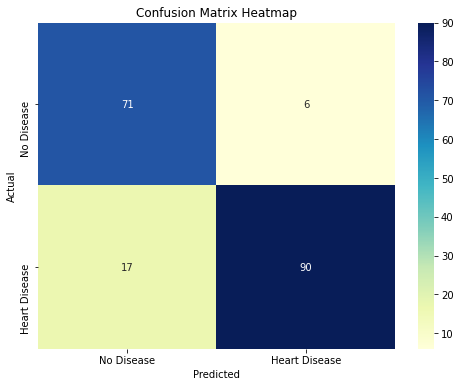

In [4]:
# 1. Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu", xticklabels=['No Disease', 'Heart Disease'], yticklabels=['No Disease', 'Heart Disease'])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



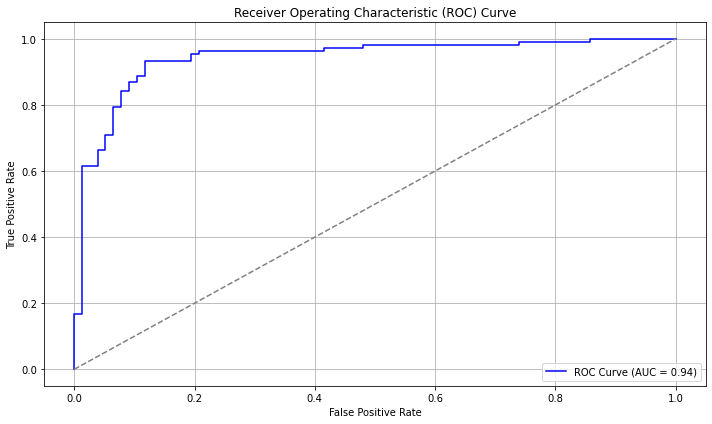

In [5]:
# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



4/4 [==============================] - 0s 2ms/step


  0%|          | 0/184 [00:00<?, ?it/s]

6394/6394 [==============================] - 9s 1ms/step


6394/6394 [==============================] - 9s 1ms/step


6394/6394 [==============================] - 9s 1ms/step


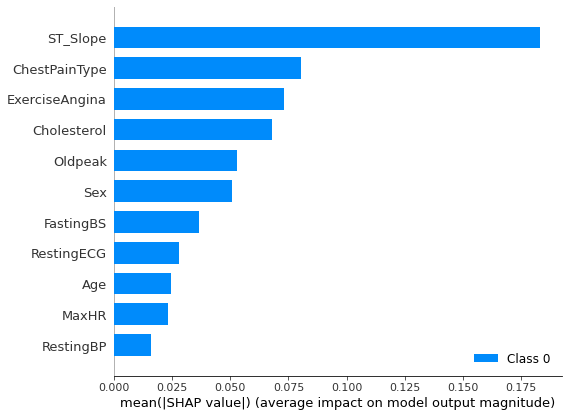

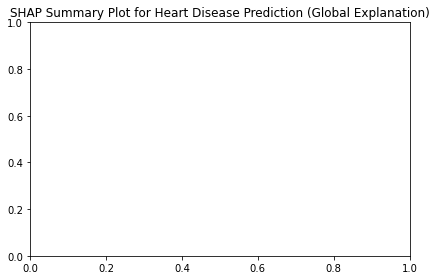

In [6]:
# 3. SHAP Summary Plot for Global Explanation
# Use SHAP's kmeans to reduce background data to 100 samples (you can adjust this number)
background_data = shap.kmeans(X_train_scaled, 100)

# Initialize SHAP explainer with the reduced background dataset
explainer = shap.KernelExplainer(model.predict, background_data)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled)




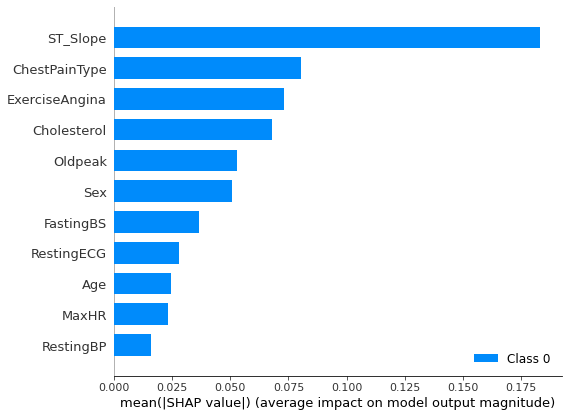

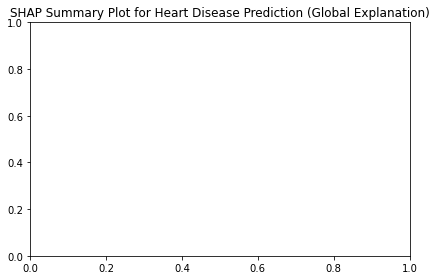

In [15]:
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test)
plt.title("SHAP Summary Plot for Heart Disease Prediction (Global Explanation)")
plt.tight_layout()
plt.show()

In [8]:
# 4. SHAP Force Plot: Local explanation for the first prediction
shap.initjs()

# For a binary classification problem (heart disease prediction: 0 or 1)
# Use the expected_value (base value) as the first parameter in the force plot
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features=X_test.iloc[0], feature_names=X_test.columns)


In [9]:

# # 4. SHAP Force Plot: Local explanation for the first prediction
# shap.initjs()
# shap.force_plot(shap_values[0][0], features=X_test.iloc[0], feature_names=X_test.columns)

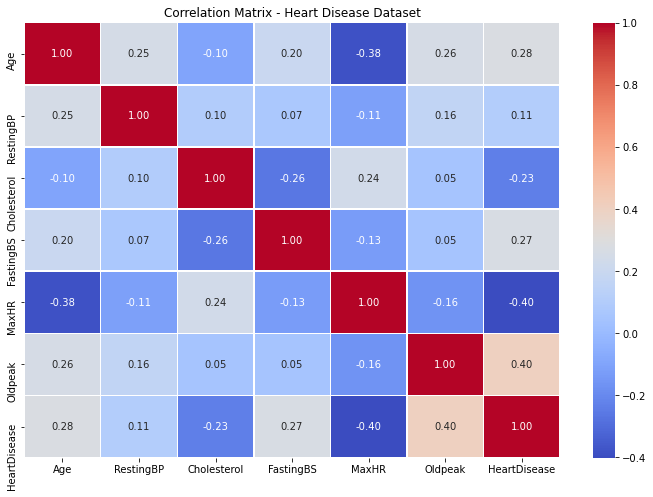

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
data_path = r"C:\Users\Ameya\Documents\EB1A\Projects\StrokeDS\heart.csv"
data = pd.read_csv(data_path)

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()  # Calculate correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix - Heart Disease Dataset")
plt.show()





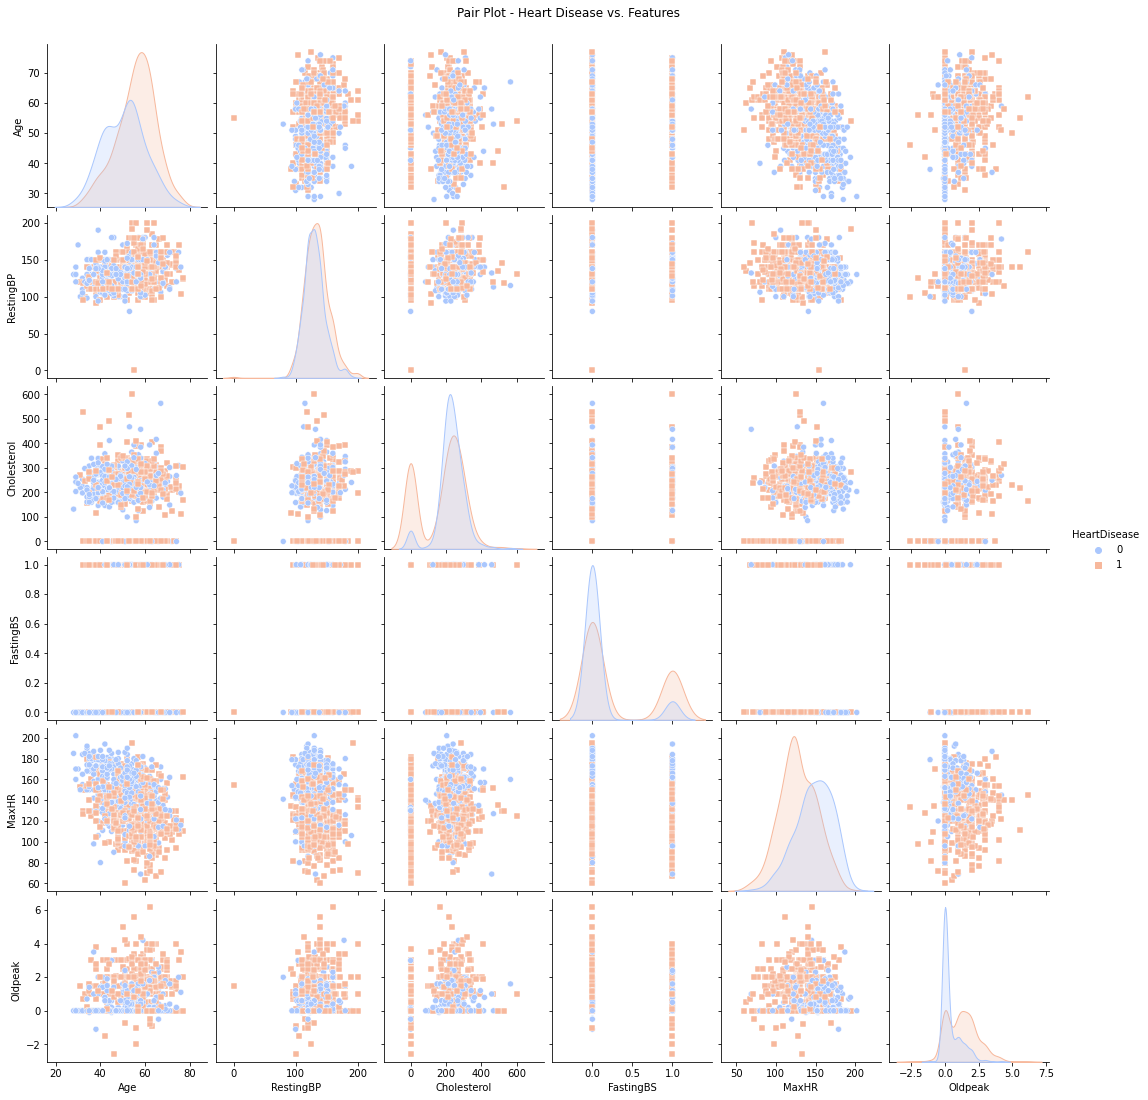

In [13]:
# Pairplot to visualize relationships between features and target (HeartDisease)
sns.pairplot(data, hue="HeartDisease", diag_kind="kde", markers=["o", "s"], palette="coolwarm")
plt.suptitle("Pair Plot - Heart Disease vs. Features", y=1.02)
plt.show()


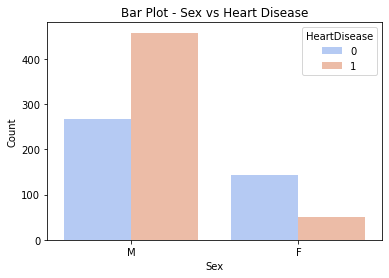

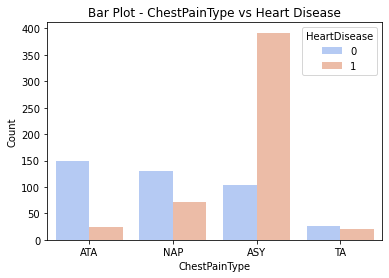

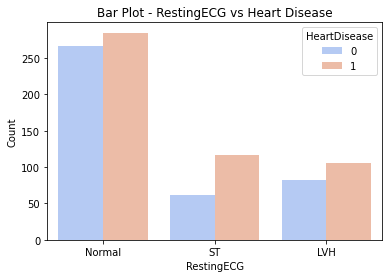

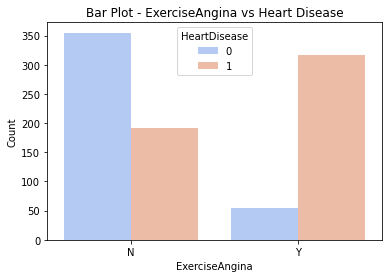

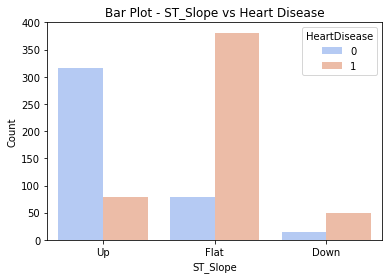

In [14]:

# Bar plot for categorical variables with Heart Disease
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for col in categorical_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue='HeartDisease', data=data, palette="coolwarm")
    plt.title(f"Bar Plot - {col} vs Heart Disease")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

In [17]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

# Define the custom classifier using TensorFlow Keras
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, optimizer='adam', activation='relu', units=32, epochs=100, batch_size=32):
        self.optimizer = optimizer
        self.activation = activation
        self.units = units
        self.epochs = epochs
        self.batch_size = batch_size

    def build_model(self):
        model = Sequential()
        model.add(Dense(self.units, input_dim=X_train_scaled.shape[1], activation=self.activation))
        model.add(Dense(16, activation=self.activation))
        model.add(Dense(8, activation=self.activation))
        model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification
        model.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [30, 50, 100],
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'tanh'],
    'units': [32, 64, 128]
}

# Initialize the custom classifier wrapper
model = KerasClassifierWrapper()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

# Fit the model using GridSearchCV
grid_search_result = grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search_result.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_model = grid_search_result.best_estimator_

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy with Best Model: {test_accuracy:.2f}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Hyperparameters: {'activation': 'tanh', 'batch_size': 32, 'epochs': 30, 'optimizer': 'adam', 'units': 128}
6/6 [==============================] - 0s 3ms/step - loss: 0.3336 - accuracy: 0.8587
Test Accuracy with Best Model: 0.86
